# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) DBSCAN (and an Introduction to Latent Dirichlet Allocation)
Week 7 | Lesson 4.2

## Introduction: DBSCAN

So far you've learned about two types of clustering algorithms - k-means clustering and hierarchical clustering. Now, we're going to learn about one last clustering algorithm - density-based spatial clustering of applications with noise, or as we'll call it from now on, DBSCAN. DBSCAN is actually probably the most widely used and applicable clustering algorithm - given that it takes minimum predefined input and can discover clusters of any shape, not just the sphere-like clusters that k-means often computes. This way, we can discover less pre-defined patterns and glean some more useful insights. Remember you are generally clustering in an unsupervised way, and with difficulty visualising the data to get much insight into what sensible numbers of clusters really would be.

#### How does DBSCAN Work?

DBSCAN is a density based clustering algorithm, meaning that the algorithm finds clusters by seeking areas of the dataset that have a higher density of points than the rest of the dataset. Unlike in our previous examples, after you apply DBSCAN there may be datapoints that _aren't assigned to any cluster at all!_ This actually means that DBSCAN generally can give more sensible results than the other algorithms because it can ignore outliers. This can also be really useful for detecting outliers.

When we use DBSCAN, it requires two input parameters: **epsilon**, which is the maximum distance between two points for them to be considered a cluster (maximum cluster radius), and **minimum points**, the minimum number of points necessary to form a cluster (this prevents outliers or small outlier groups from becoming their own cluster). Hence we define a density - both the volume (defined by the distance as a radius) and the effective mass (defined by the number of points within the volume). You must choose these parameters by some trial-and-error, and domain knowledge. There is a variation of DBSCAN called OPTICS which runs a search across epsilon parameters, but this has not been implemented in sklearn - in fact, somewhat incredibly there is a pull request for this feature which is still actively being commented and tweaked three years after its initial submission (see [here](https://github.com/scikit-learn/scikit-learn/pull/1984)).

We might naively suppose that we can simply assign points to a cluster if they have at least the minimum number of points within their epsilon distance volume (which we refer to as their _neighbourhood_), and that all points that are reachable by directly moving from one epsilon volume to another without gaps in between are hence in the same cluster. However we must tweak this to include a concept of core and border points. Intuitively, the density of points on the edge of the cluster must be significantly lower than in the core - so we must treat these differently. Therefore the requirement is broadened such that for any point considered to be part of a cluster, there must be within its neighbourhood some point which has the minimum points within its own neighbourhood. The algorithm will work sequentially, taking an initial starting data point and considering whether it sits within a cluster based on passing the minimum points threshold within its neighbourhood. If so it moves on to all the points in the neighbourhood and performs an assessment on whether those points are also core points or are border points. We would not move on and assess points in a border point's neighbourhood for placement in the cluster. This carries on until all points directly reachable have been labelled as core or border. Once one cluster is finalised, the algorithm then moves to a new datapoint, and seeks to find related points to form yet another cluster; this will continue until DBSCAN simply runs out of data points. Hence in this case, we only consider our data points when considering distances (we never make reference to arbitrary points in space).

This [website](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/) does a good job of showing how the algorithm passes through points and develops the cluster. 

[Here](./assets/papers/dbscan.pdf) is the original paper describing dbscan.


#### How does DBSCAN differ from K-Means and Hierarchical Clustering? 

Whereas k-means can be thought of as a "general" clustering approach, DBSCAN performs especially well with unevenly distributed, non-linear clusters. The fundamental difference with DBSCAN lies in the fact that it is *density based* rather than k-means, which calculates clusters based on distance from a central point, or hierarchical clustering. When choosing epsilon in the minimum points in DBSCAN, a selection of < 2 will result in a linkage cluster - essentially the same result as if you were to perform a hierarchical clustering. To diversify the DBSCAN, we therefore must give it a significant amount of points to form a cluster.

DBSCAN can be particularly useful to us when we have a lot of dense data. If we used k-means on this data, the algorithm would effectively give us just one large cluster! However with DBSCAN, we can actually break down this cluster into smaller groups to see their attributes. Additionally DBSCAN performs well with outliers, which will not skew the clustering (since points can be assigned to no cluster).

**Check:** What does it do differently from k-means and hierarchical clustering?


In [1]:
from sklearn.cluster import DBSCAN
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

% matplotlib inline

In [2]:
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.3, random_state=0)
X = StandardScaler().fit_transform(X)

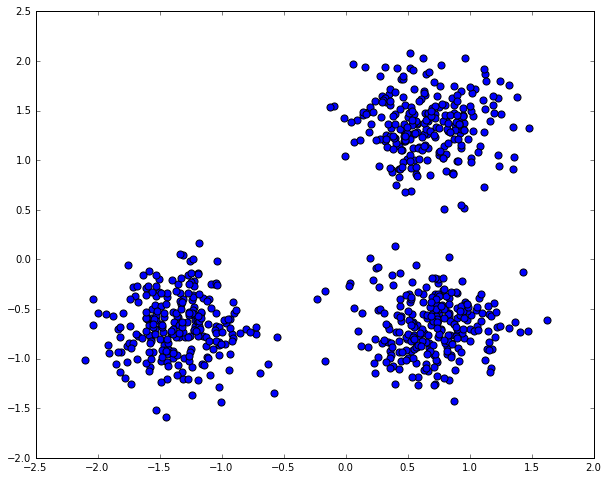

In [3]:
fig = plt.figure(figsize=(10,8))
plt.scatter(X[:,0], X[:,1], s=50)
plt.show()

In [4]:
db = DBSCAN(eps=0.3, min_samples=10)
db.fit(X)

DBSCAN(algorithm='auto', eps=0.3, leaf_size=30, metric='euclidean',
    min_samples=10, n_jobs=1, p=None)

In [5]:
core_samples = db.core_sample_indices_
labels = db.labels_

# the core samples lists the core points, if a point is within a cluster
# but not in the core then it is a border point, but still classified in the cluster
# (this isn't particularly critical for the interpretation but it is important for the way DBSCAN
# is implemented - you can read more on the sklearn documentation)

# the labels are 0,1,2 for the three clusters and -1 for unassigned
print("Labels:")
print(np.unique(labels))

Labels:
[-1  0  1  2]


In [6]:
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Hence number of actual clusters is:")
print(n_clusters)

Hence number of actual clusters is:
3


In [18]:
from sklearn.metrics import silhouette_score

print("Silhouette Coefficient: %0.3f"
      % silhouette_score(X, labels))

/Users/generalassembly/anaconda2/lib/python2.7/site-packages/matplotlib/lines.py:1145: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


In [21]:
from sklearn import metrics
y = labels_true
print('Estimated number of clusters: %d' % n_clusters)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(y, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 3
Homogeneity: 0.989
Completeness: 0.949
V-measure: 0.969
Adjusted Rand Index: 0.984
Adjusted Mutual Information: 0.948
Silhouette Coefficient: 0.660


C:\Anaconda2\lib\site-packages\matplotlib\lines.py:1106: UnicodeWarning: Unicode unequal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self._markerfacecolor != fc:


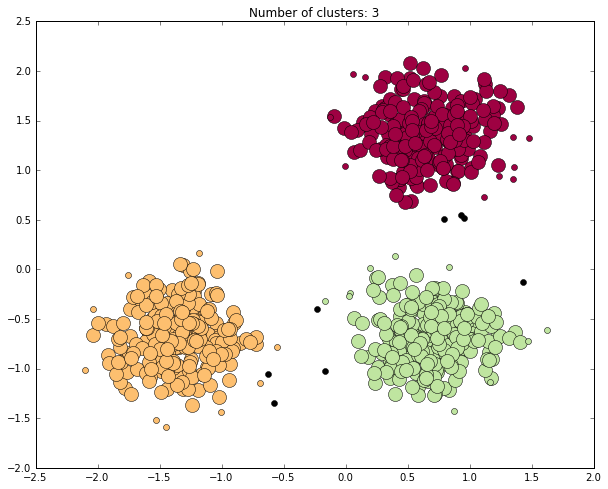

In [20]:
fig = plt.figure(figsize=(10,8))
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'
    class_member_mask = (labels == k)
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)
plt.title('Number of clusters: %d' % n_clusters)
plt.show()

# Latent Dirichlet Allocation

I thought I would add in some extra material on Latent Dirichlet Allocation (LDA) because it's pretty interesting and useful tool for assigning text into topics. This wasn't originally in the syllabus so its introduction here does perhaps skip a few topics, so my aim is more to expose you to the tool and get you thinking if it might be useful for eg your project if you want to explore further. Note that you can also use a PCA and clustering approach to understanding topics, and we have a look at this in the lab bonus, but the performance is likely to be poorer and additionally there are some very useful tools that have been developed specifically for topic modelling with text that make it very sensible to treat this problem separately from other types of data.

The implementation of LDA works on Bayesian statistics which we will look at next week. To simplify, it essentially clusters documents into topics based on the frequency of particular words (i.e. bag-of-words) that appear together. It does this by assuming a probability distribution of words (which is the Dirichlet distribution - a fairly standard one for Bayesian statistics). You must input the number of topics you expect as a parameter, and the model will work to assign probabilities for each word to appear within a topic based on its varying appearance in different documents in the corpus. Crucially, it will iteratively pass over its allocation of words to topics multiple times in order to update its model and in the end it will be able to assign any unseen document a probability of being in each of the defined topics. The model is generative, in that it can arbitrarily create new documents following some combination of the topics (being a bag-of-words). This process implies an inherent dimensionality reduction but when it comes to interpreting those topics, that must be done by the data scientist through introspection of the selected words. Note that words are not uniquely assigned to one topic or another, but they are generated with a different probability from different topics and we typically would introspect only the highest ranked words to form a topic label.

I would encourage you to take a look at the original 2003 paper in which this model was proposed (co-authored by the famous Andrew Ng) [here.](./assets/papers/latent_dirichlet_allocation.pdf)

In [12]:
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
pyLDAvis.enable_notebook()

In [13]:
# fetching 20 news groups text data

newsgroups = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))
docs_raw = newsgroups.data

In [14]:
# We perform a tfidf vectorisation of the words in each document

tf_vectorizer = CountVectorizer(strip_accents = 'unicode', stop_words = 'english', lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b', max_df = 0.5,  min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(docs_raw)

In [15]:
# We run the latent dirichlet allocation model with a belief there are 20 distinct topics

lda_tf = LatentDirichletAllocation(n_topics=20, random_state=0)
lda_tf.fit(dtm_tf)

C:\Anaconda2\lib\site-packages\sklearn\decomposition\online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_jobs=1, n_topics=20, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [16]:
# Note the pyLDAvis module performs its own dimensionality reduction in order to display
# this image, so the topic model will exist in a higher dimensional space and hence
# the display represents only a simplification intended to visualise the separation of topics

pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
15     10.823712        1       1 -0.092144 -0.139924
12      8.300551        1       2 -0.202586  0.013026
4       8.237988        1       3 -0.227601  0.049152
6       7.815383        1       4 -0.071434 -0.047499
0       7.529769        1       5 -0.152673  0.006487
14      6.829115        1       6 -0.097501  0.107442
9       6.519449        1       7  0.065267 -0.105437
13      6.480666        1       8 -0.120288 -0.083854
5       6.442044        1       9 -0.191532  0.091312
8       5.365540        1      10 -0.144040  0.043591
2       4.779361        1      11  0.164598 -0.219685
1       3.899585        1      12 -0.164470  0.025632
18      3.288486        1      13 -0.010929 -0.146494
16      2.745557        1      14  0.153248  0.252591
10      2.693579        1      15  0.183087  0.008268
7       2.446077        1      16  0.136747 -0.065023
19      2.278135        1      17  0.201555  0.040887
3       1.845921        1      18  0.199580 -0.161042
11      0.902157        1      19  0.190450  0.121579
17      0.776925        1      20  0.180665  0.208991, topic_info=     Category         Freq        Term        Total  loglift  logprob
term                                                                 
5016  Default  4394.000000         max  4394.000000  30.0000  30.0000
2653  Default  2391.000000         edu  2391.000000  29.0000  29.0000
3523  Default  2039.000000         god  2039.000000  28.0000  28.0000
1506  Default  1432.000000         com  1432.000000  27.0000  27.0000
3153  Default  1678.000000        file  1678.000000  26.0000  26.0000
2560  Default  1140.000000       drive  1140.000000  25.0000  25.0000
4895  Default  1183.000000        mail  1183.000000  24.0000  24.0000
8982  Default  1192.000000     windows  1192.000000  23.0000  23.0000
4543  Default  3503.000000        know  3503.000000  22.0000  22.0000
4769  Default   933.000000        list   933.000000  21.0000  21.0000
7677  Default  1263.000000       space  1263.000000  20.0000  20.0000
2509  Default  3876.000000         don  3876.000000  19.0000  19.0000
2077  Default  1232.000000        data  1232.000000  18.0000  18.0000
5924  Default  4066.000000      people  4066.000000  17.0000  17.0000
912   Default   649.000000        book   649.000000  16.0000  16.0000
627   Default  1321.000000   available  1321.000000  15.0000  15.0000
7329  Default   841.000000        send   841.000000  14.0000  14.0000
7629  Default   946.000000    software   946.000000  13.0000  13.0000
6362  Default  1377.000000     program  1377.000000  12.0000  12.0000
3986  Default   682.000000       image   682.000000  11.0000  11.0000
4468  Default  3743.000000        just  3743.000000  10.0000  10.0000
3156  Default   831.000000       files   831.000000   9.0000   9.0000
4396  Default   862.000000       jesus   862.000000   8.0000   8.0000
8278  Default  2997.000000       think  2997.000000   7.0000   7.0000
3551  Default  1211.000000  government  1211.000000   6.0000   6.0000
2517  Default   678.000000         dos   678.000000   5.0000   5.0000
8252  Default  1249.000000      thanks  1249.000000   4.0000   4.0000
1161  Default   812.000000        card   812.000000   3.0000   3.0000
8167  Default   800.000000        team   800.000000   2.0000   2.0000
7250  Default   620.000000        scsi   620.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
8050  Topic20   100.947391   surrender   101.893082   4.8483  -4.1431
5547  Topic20    98.664750         nyi    99.610438   4.8480  -4.1660
5549  Topic20    99.663611         nyr   100.645122   4.8478  -4.1559
1614  Topic20    94.986822    compound    95.932834   4.8477  -4.2040
7552  Topic20    85.149172  skepticism    86.094860   4.8465  -4.3133
7860  Topic20   110.355515         stl   111.598819   4.8464  -4.0540
2650  Topic20    77.915052         edm 